<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# Описание проекта


Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# Описание данных

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

# Инструкция по выполнению проекта

## Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import  OneHotEncoder
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
 

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',index_col=[0], parse_dates=[0])



## Анализ

In [3]:
display(data.head())
display(data.info())#нет пропусков
display(data.duplicated().sum())#нет дубликатов


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

26415

In [4]:
print(data.index.is_monotonic)

True


In [5]:
data = data.resample('1H').sum()
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

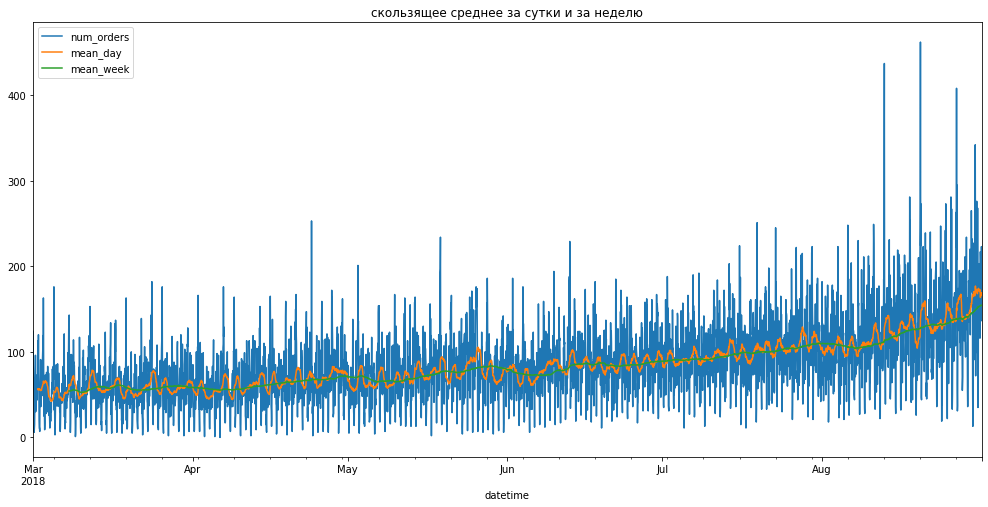

In [6]:
df= data.resample('1H').sum()
df['mean_day'] = df['num_orders'].rolling(24).mean()
df['mean_week'] = df['num_orders'].rolling(7*24).mean()
df.plot(figsize=(17,8),title="скользящее среднее за сутки и за неделю");


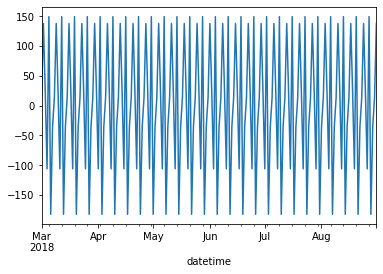

In [7]:
seasonal_decompose(df['num_orders'].resample('1D').sum()).seasonal['2018-03-1':'2018-08-31'].plot(ax=plt.gca());

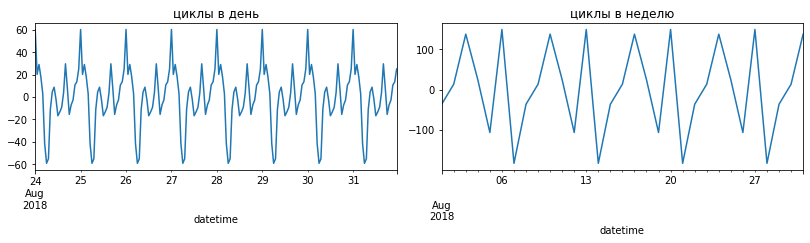

In [8]:
decompose = seasonal_decompose(data)

plt.figure(figsize=(17, 15))


plt.subplot(531)
plt.title('циклы в день')
decompose.seasonal['2018-08-24':'2018-08-31'].plot(ax=plt.gca())



plt.subplot(532)
plt.title('циклы в неделю')
seasonal_decompose(df['num_orders'].resample('1D').sum()).seasonal['2018-08-1':'2018-08-31'].plot(ax=plt.gca());



plt.tight_layout()

### Вывод:

тренд указивает что c августа есть тренд на подем.будет больше заказов. 
так же видим что меньше всего заказов в 6 утра а максимум в полноч хотя и есть пик заказов где то в 16:00
Стохастический процесс стационарный у шума
в данных есть сезонность суточная недельная

## Обучение

In [9]:
def make_features(data, max_lag, rolling_mean_size):

    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 24, 168)


In [10]:
cats=["hour","dayofweek"]

In [11]:
data_cat=data.copy()



In [12]:
df=data.copy()
df= df.dropna()
for i in df[cats]:
    df[i]=df[i].astype('category')

#train, test = train_test_split(df, shuffle=False, test_size=0.1)
train,test = train_test_split(df, test_size = 0.1 ,shuffle = False, random_state = 1)
#valid,test = train_test_split(test, test_size = 0.5,shuffle = False, random_state = 1)
    
features = train.drop(['num_orders'], axis = 1)  
target = train['num_orders'] 

# features_valid = valid.drop(['num_orders'], axis = 1)  
# target_valid = valid['num_orders'] 


features_test = test.drop(['num_orders'], axis = 1)  
target_test = test['num_orders'] 

f_cat=features.copy()
t_cat=target.copy()


df2=data.copy()
df2= df2.dropna()
train2, test2 = train_test_split(df2, test_size=0.1,shuffle = False, random_state = 1)
#valid2, test2 = train_test_split(test2, test_size=0.5,shuffle = False, random_state = 1)

f_lgbm = train2.drop(['num_orders'], axis = 1)  
t_lgbm = train2['num_orders'] 

# f_lgbm_valid = valid2.drop(['num_orders'], axis = 1)  
# t_lgbm_valid = valid2['num_orders'] 

# f_lgbm_test = test2.drop(['num_orders'], axis = 1)  
# t_lgbm_test = test2['num_orders'] 

In [13]:
cv =TimeSeriesSplit(n_splits=5)

In [14]:
mod_cat=CatBoostRegressor( loss_function = 'RMSE',eval_metric = 'RMSE',cat_features =cats,learning_rate=0.3)
model_lgbm= LGBMRegressor(metric="rmse",learning_rate=0.3)



In [15]:
params={
        'max_depth' : [3,6],
        'n_estimators' : [110],
       }

In [16]:
oh=data.copy()
for i in oh[cats]:
    oh[i]=oh[i].astype('object')
    
t2 = oh['num_orders']
f2 = oh.drop('num_orders', axis=1)

f2_train, f2_test, t2_train, t2_test = train_test_split(f2, t2, test_size=0.2,shuffle = False, random_state = 1)
f2_valid, f2_test, t2_valid, t2_test = train_test_split(f2_test, t2_test, test_size=0.5,shuffle = False, random_state = 1)

# train,test = train_test_split(df,shuffle = False, test_size = 0.2)
# valid,test = train_test_split(test,shuffle = False, test_size = 0.5)

en = OneHotEncoder(handle_unknown="ignore")
en.fit(f2_train) 

f2_valid= en.transform(f2_valid)
f2_train = en.transform(f2_train)
f2_test = en.transform(f2_test)

model_ohe = LinearRegression()




In [17]:

gcat_cat= GridSearchCV(mod_cat, params, cv=cv,scoring='neg_root_mean_squared_error')

g_lgbm= GridSearchCV(model_lgbm, params, cv=cv, scoring='neg_root_mean_squared_error')



In [18]:
%%time
gcat_cat.fit(f_cat, t_cat,verbose=False)

CPU times: user 4.15 s, sys: 228 ms, total: 4.38 s
Wall time: 10.8 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f5b7b4160d0>,
             param_grid={'max_depth': [3, 6], 'n_estimators': [110]},
             scoring='neg_root_mean_squared_error')

In [19]:
display("Catboost  с кат признаками",gcat_cat.best_score_,gcat_cat.best_params_)

'Catboost  с кат признаками'

-25.142491443130915

{'max_depth': 3, 'n_estimators': 110}

In [20]:
%%time
model_ohe.fit(f2_train, t2_train) 

CPU times: user 64.5 ms, sys: 0 ns, total: 64.5 ms
Wall time: 63.8 ms


LinearRegression()

In [21]:
p=model_ohe.predict(f2_valid)
rm = mean_squared_error(t2_valid, p)**0.5
display("OHE LIN с кат признаками",rm)

'OHE LIN с кат признаками'

43.98222966770109

In [22]:
%%time
g_lgbm.fit(f_lgbm, t_lgbm)

CPU times: user 5min 41s, sys: 2.07 s, total: 5min 43s
Wall time: 5min 49s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(learning_rate=0.3, metric='rmse'),
             param_grid={'max_depth': [3, 6], 'n_estimators': [110]},
             scoring='neg_root_mean_squared_error')

In [23]:

display("LGBM без кат признаков",g_lgbm.best_score_,g_lgbm.best_params_)


'LGBM без кат признаков'

-25.85524782175048

{'max_depth': 3, 'n_estimators': 110}

у всех моделей резултаты RMSE ниже 48 на валидационной выборке(OHE 43.9 Catboost 25.14 LGBM 25.85)
на тестирование идет catboost

## Тестирование

In [24]:
b= gcat_cat.best_estimator_.predict(features_test)
brm = mean_squared_error(target_test,b)**0.5
display("Catboost  с кат признаками",brm)

'Catboost  с кат признаками'

42.281350788643145

# Вывод